In [3580]:
import pandas as pd
import numpy as np
import networkx as x

# WORK IN PROGRESS

## Dynamics

We assume t-cell dynamics as below as from [Almocera et al](https://www.biorxiv.org/content/biorxiv/early/2017/08/11/174961.full.pdf), but with lysis (from NK cells) and delayed replication start as a separate state

    dI/dt = p V (1 - V/Kv) - I/t
    dV/dt =  I/t - (cE + l)V
    
    dE/dt = (E0 - E)δe + G(V)E
    
    p = Ro * (1 - (c E + l) + l m) # 
    
    
    G(I) = rV/(V + Ke) 
    
    R0 = pδe/(cv Ne)
    
 TODO: Model the regulation of NK cells (for lysis / apoptosis), instead of assuming they kill only through lysis a fixed rate

The slow virus takes sixty times as long to start producing copies

In [4436]:
r_slow = 1e-2
r_fast = r_slow
carrying_v = 6e5
carrying_e = 3e3
delta_e = 3e-2
e_0 = 1e6
r0_fast = .5
t_fast = 1
c_v = 1e-6
t_slow = t_fast * 10
lysis_multiplier = 2
lysis_rate = 1e-2
r0_slow = r0_fast

In [4442]:
def compute(I, V, E, r, carrying_v, carrying_e, delta_e, e_0, c_v, r0, t, initial, lysis_multiplier, lysis_rate):
    for period in range(len(V) - 1):
        I_old = I[period]
        V_old = V[period]
        E_old = E[period]
        p = r0 * (max(0, (1  - c_v * E_old - lysis_rate)) + lysis_rate * lysis_multiplier)
        flux_I_infection =  max(0, p * V_old * (1 - (V_old + I_old)/carrying_v))
        flux_I_lysis = lysis_rate * I_old
        flux_V_ready = I_old/t 
        flux_V_lysis = lysis_rate * V_old
        flux_V_cleanup = c_v * V_old
        flux_E = (e_0 - E_old) * delta_e + r * V_old / (V_old + carrying_e) * E_old
        I.loc[period + 1] = int(max(0, I_old + flux_I_infection - flux_V_ready - flux_I_lysis))
        V.loc[period + 1] = int(max(0, V_old - flux_V_cleanup + flux_V_ready - flux_V_lysis))
        E.loc[period + 1] = int(max(0, E_old + flux_E))

In [4443]:
initial_infections = [1e2] #np.linspace(1e1, 1e3, 5)
# initial = 1e6
allele_multipliers = np.arange(.2, 2, .2)

In [4444]:
results_I = []
results_V = []
results_E = []
results_fast_I = []
results_fast_V = []
results_fast_E = []
for initial in initial_infections:
    for a in allele_multipliers:
        slow = pd.DataFrame(np.zeros((1000, 3)), index=range(1000), columns=['I', 'V', 'E'])
        fast = pd.DataFrame(np.zeros((1000, 3)), index=range(1000), columns=['I', 'V', 'E'])
        slow.loc[0, :] = (initial, 0, e_0)
        fast.loc[0, :] = (initial, 0, e_0)
        compute(slow['I'], slow['V'], slow['E'], r_slow, carrying_v, carrying_e, delta_e, e_0, c_v * a, r0_slow, t_slow, initial, lysis_multiplier, lysis_rate)
        compute(fast['I'], fast['V'], fast['E'], r_fast, carrying_v, carrying_e, delta_e, e_0, c_v * a, r0_fast, t_fast, initial, lysis_multiplier, lysis_rate)
        results_I.append(slow['I'])
        results_V.append(slow['V'])
        results_E.append(slow['E'])
        results_fast_I.append(fast['I'])
        results_fast_V.append(fast['V'])
        results_fast_E.append(fast['E'])

In [4445]:
trajectories = pd.concat(results_V, axis=1)
trajectories_fast = pd.concat(results_fast_V, axis=1)

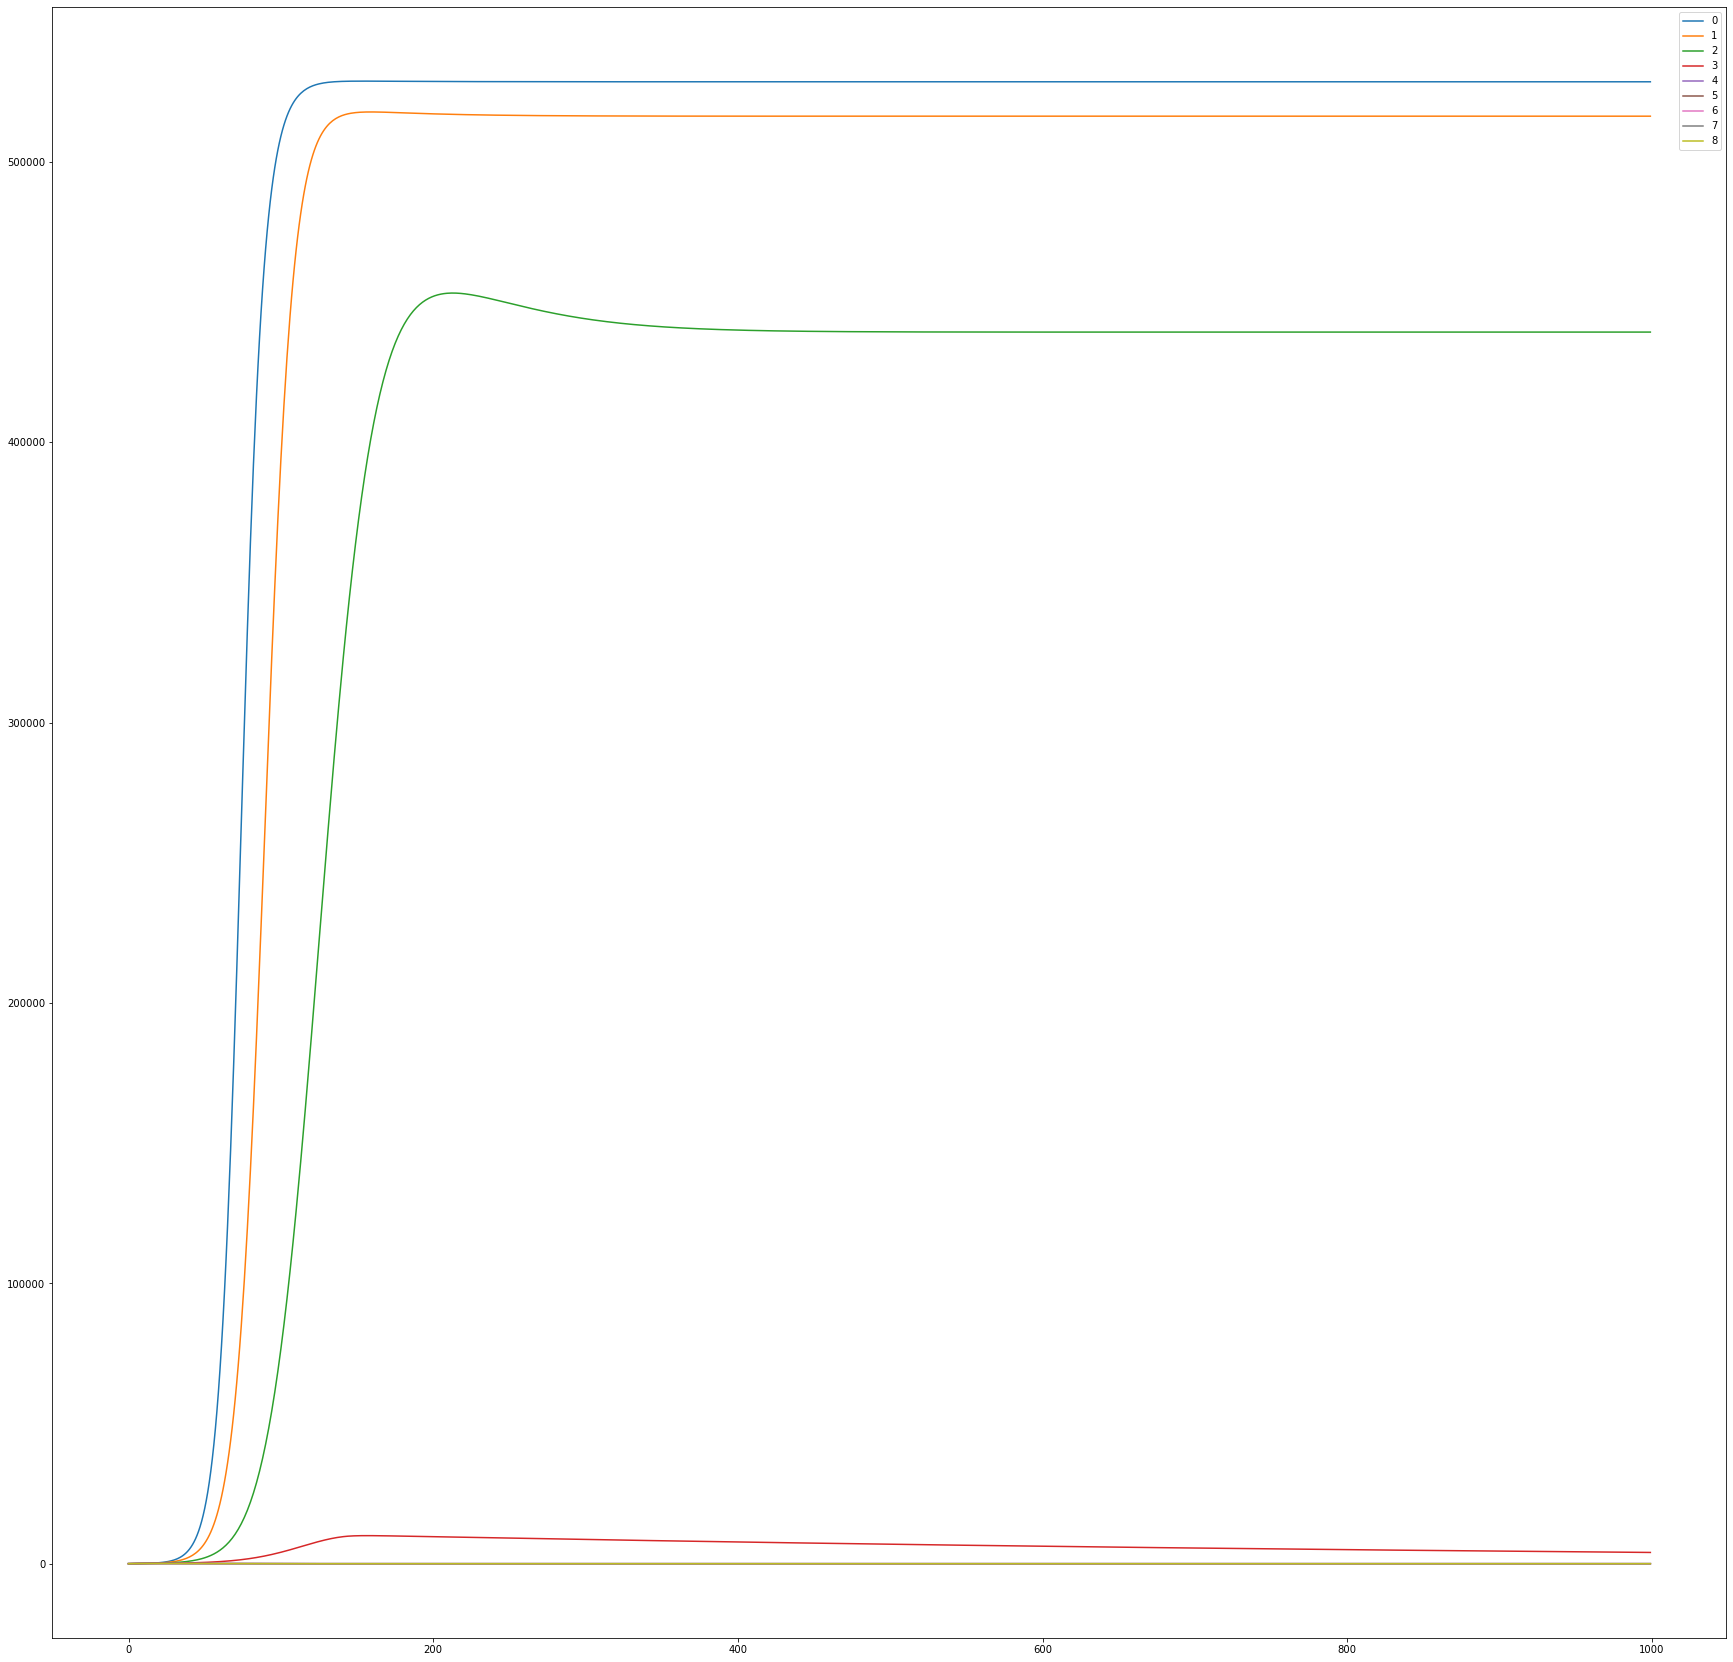

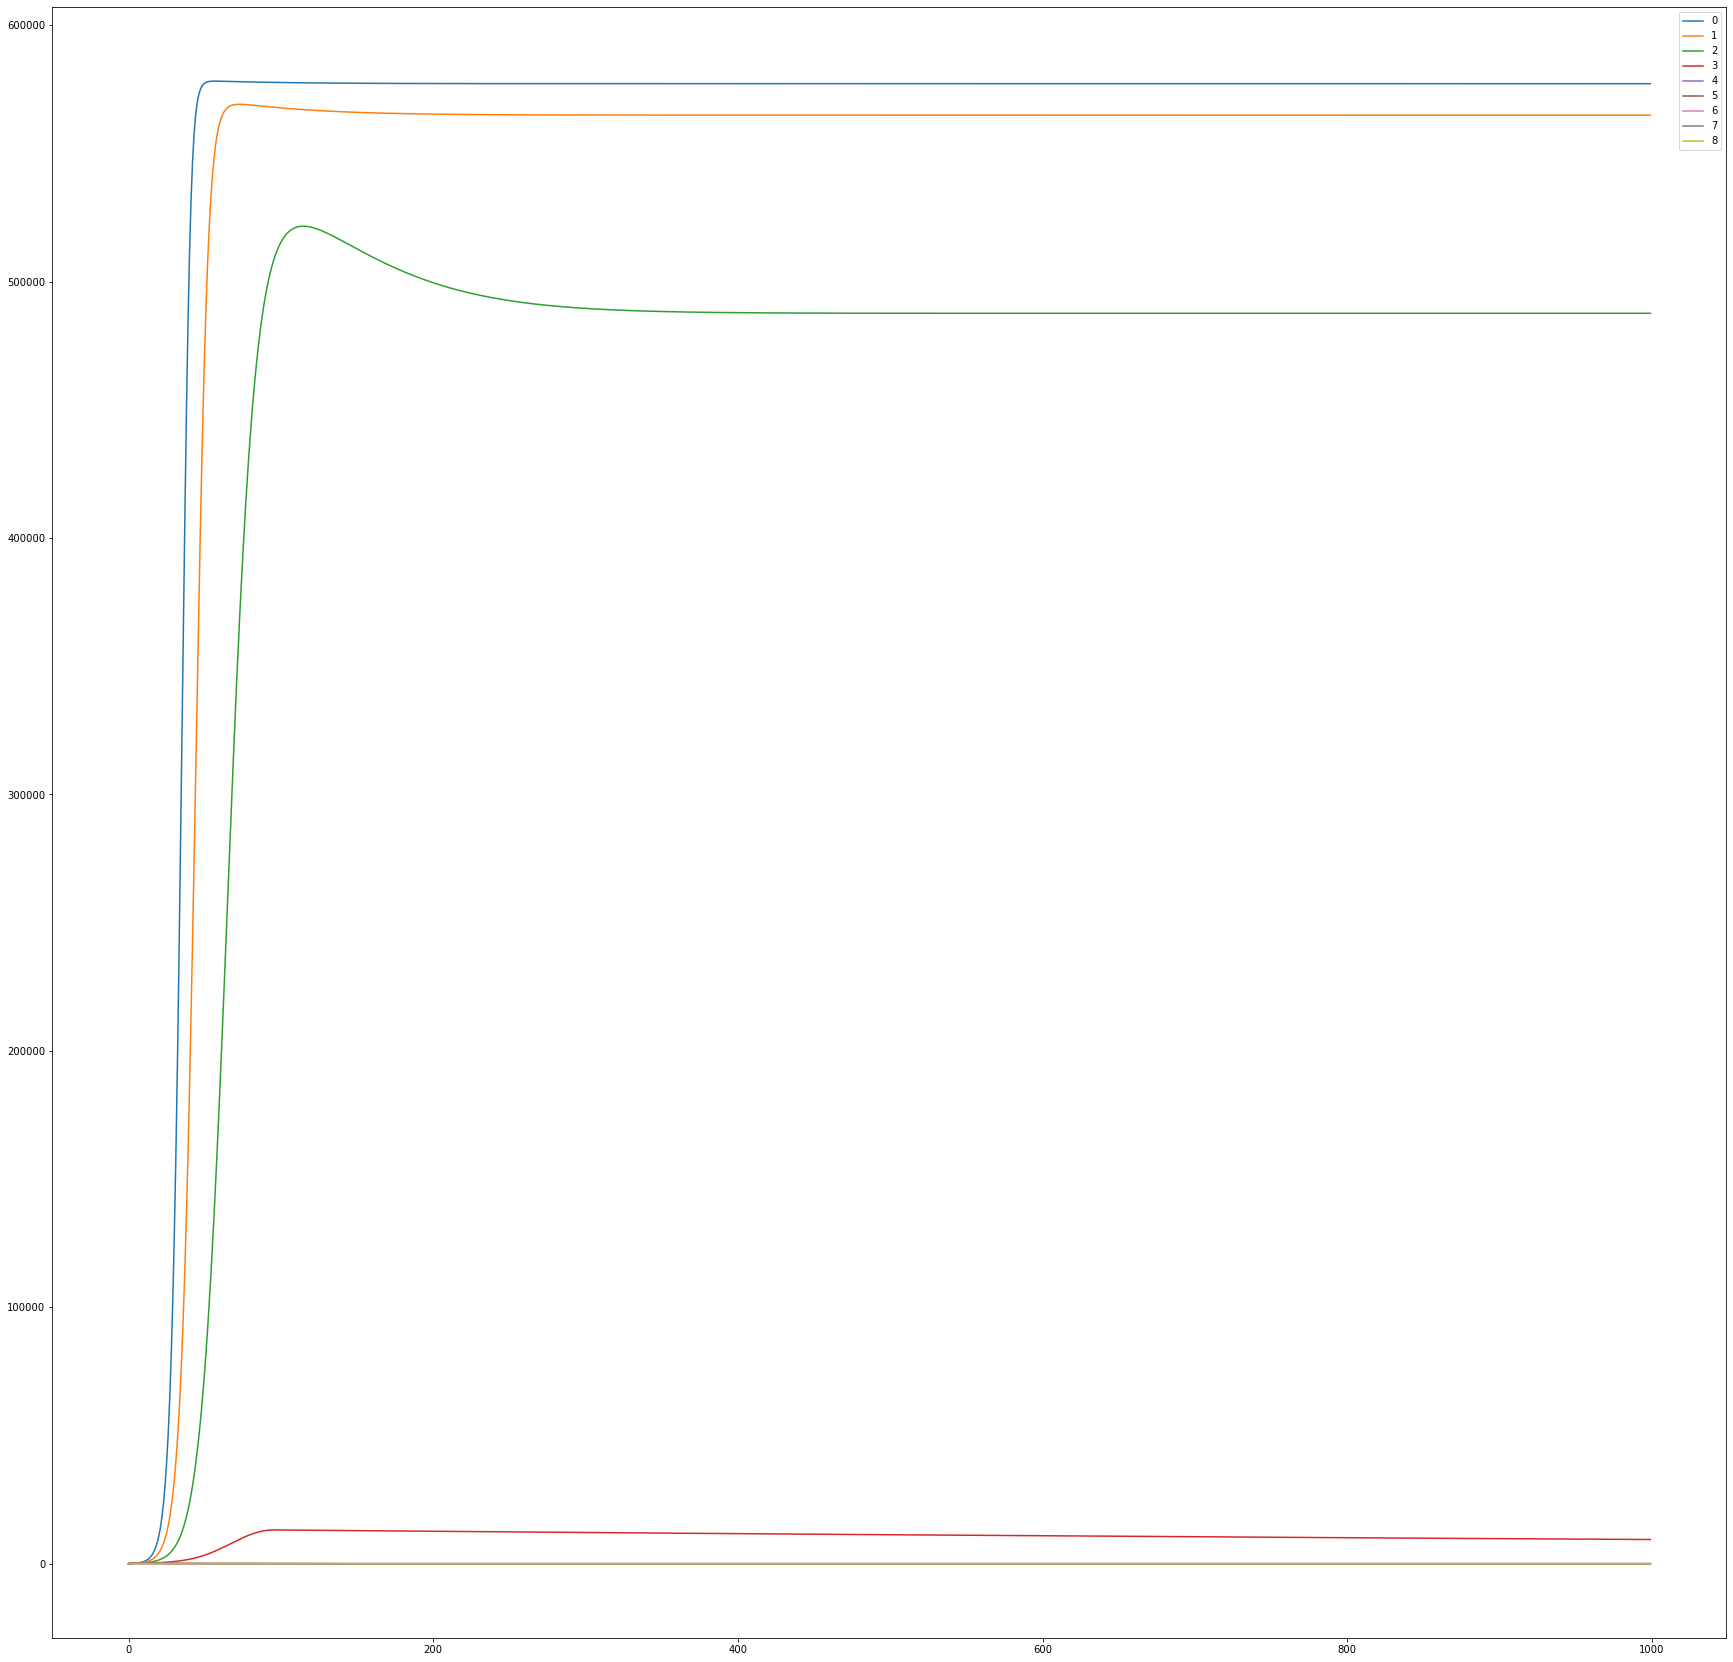

In [4446]:
trajectories.T.reset_index(drop=True).T.plot(figsize=(30, 30))
trajectories_fast.T.reset_index(drop=True).T.plot(figsize=(30, 30))